In [3]:
import napari
import numpy as np
import matplotlib.pyplot as plt
import z5py
from pathlib import Path
from skimage.measure import label

from cryofib.n5_utils import read_volume, print_key_tree, write_volume
from cryofib.napari_utils import napari_add_group

## View n5 datasets

In [12]:
postprocess_path = Path("/scratch/buglakova/data/cryofib/segm_fibsem/F107/F107_A2_em.n5/")
f_em = z5py.File(postprocess_path, "r")

In [5]:
print_key_tree(f_em)

Key structure of z5 file /scratch/buglakova/data/cryofib/segm_fibsem/F107/F107_A2_em.n5
raw
segmentation
segmentation/nuclei
input
input/raw_norm


## Read volumes

In [6]:
roi = np.s_[:, :, :]
em = read_volume(f_em, "raw", roi)


<class 'z5py.file.File'>
Reading roi (slice(None, None, None), slice(None, None, None), slice(None, None, None)) of volume raw from /scratch/buglakova/data/cryofib/segm_fibsem/F107/F107_A2_em.n5
Read volume with shape (1610, 1410, 1386), data type uint8


In [7]:
def get_zero_component(img: np.ndarray):
    bg = label(img == 20)
    component_sizes = [np.count_nonzero(bg == i) for i in np.unique(bg)[1:]]
    if len(component_sizes) == 0:
        return img > 0
    bg_ind = np.argmax(component_sizes) + 1
    bg = (bg == bg_ind)
    fg = (bg != bg_ind)
    return fg


def get_fg_mask(raw: np.ndarray):
    print("Compute foreground mask")
    print("Raw data shape: ", raw.shape)
    fg_mask = np.array([get_zero_component(img) for img in raw])
    return fg_mask

In [8]:
fg_mask = get_fg_mask(em)

Compute foreground mask
Raw data shape:  (1610, 1410, 1386)


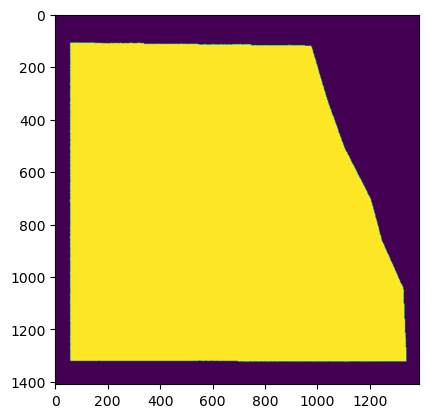

In [9]:
plt.imshow(fg_mask[500, :, :])

In [10]:
em_norm = em * fg_mask

In [13]:
write_volume(postprocess_path, em_norm, "raw_zero_bg")

<class 'pathlib.PosixPath'>
Created dataset raw_zero_bg
Writing array to raw_zero_bg


In [14]:
f_em = "/scratch/buglakova/data/cryofib/segm_fibsem/F107/F107_A2_em_thin_boundaries_predictions.n5"

In [20]:
boundaries = read_volume(f_em, "dilated_boundary_predictions/dice_16x512x512/boundaries", roi)
fg = read_volume(f_em, "dilated_boundary_predictions/dice_16x512x512/fg", roi)
extra = read_volume(f_em, "dilated_boundary_predictions/dice_16x512x512/extra", roi)

<class 'str'>
Reading roi (slice(None, None, None), slice(400, 600, None), slice(None, None, None)) of volume dilated_boundary_predictions/dice_16x512x512/boundaries from /scratch/buglakova/data/cryofib/segm_fibsem/F107/F107_A2_em_thin_boundaries_predictions.n5
Read volume with shape (1610, 200, 1386), data type float32
<class 'str'>
Reading roi (slice(None, None, None), slice(400, 600, None), slice(None, None, None)) of volume dilated_boundary_predictions/dice_16x512x512/fg from /scratch/buglakova/data/cryofib/segm_fibsem/F107/F107_A2_em_thin_boundaries_predictions.n5
Read volume with shape (1610, 200, 1386), data type float32
<class 'str'>
Reading roi (slice(None, None, None), slice(400, 600, None), slice(None, None, None)) of volume dilated_boundary_predictions/dice_16x512x512/extra from /scratch/buglakova/data/cryofib/segm_fibsem/F107/F107_A2_em_thin_boundaries_predictions.n5
Read volume with shape (1610, 200, 1386), data type float32


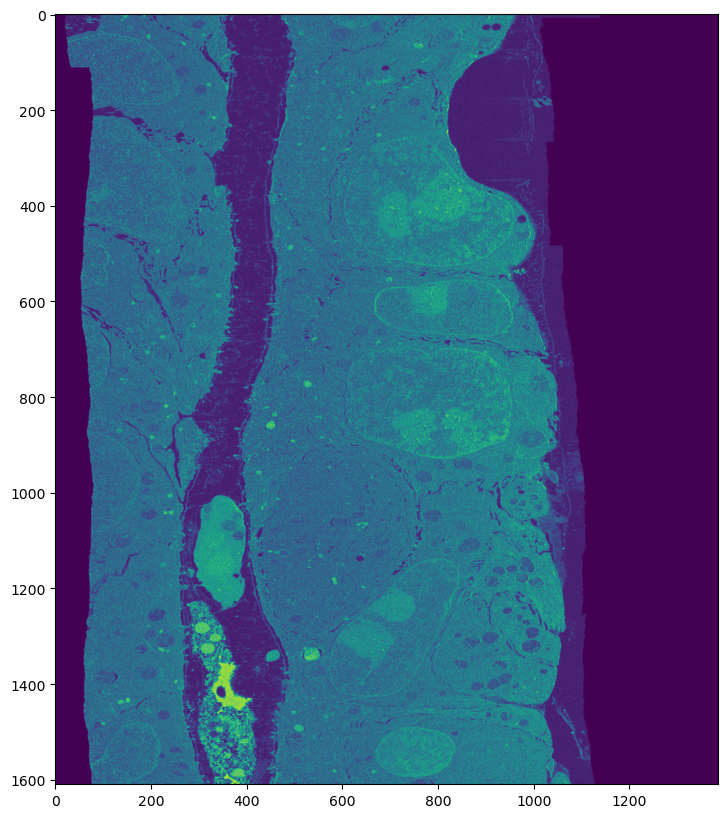

20


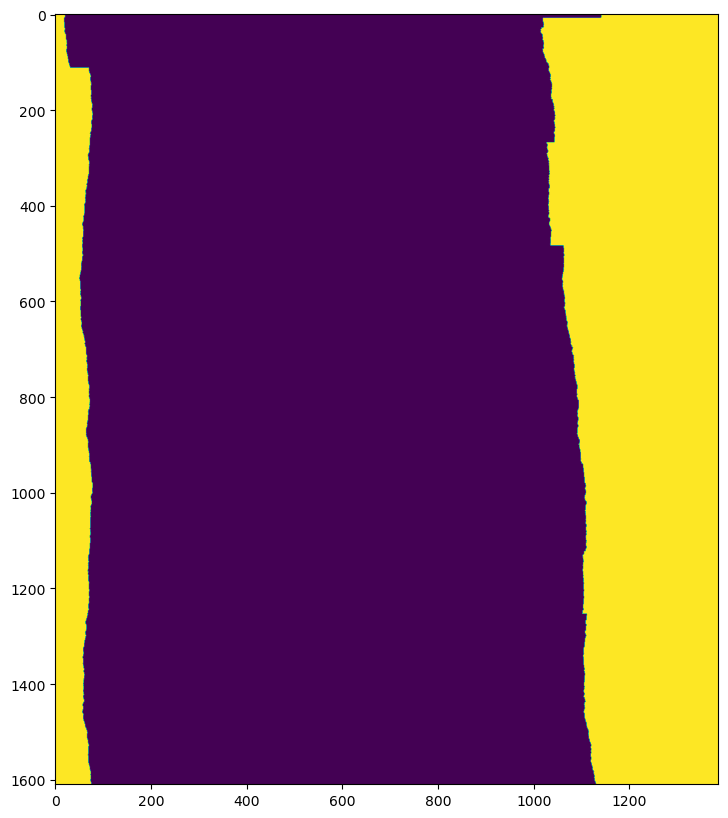

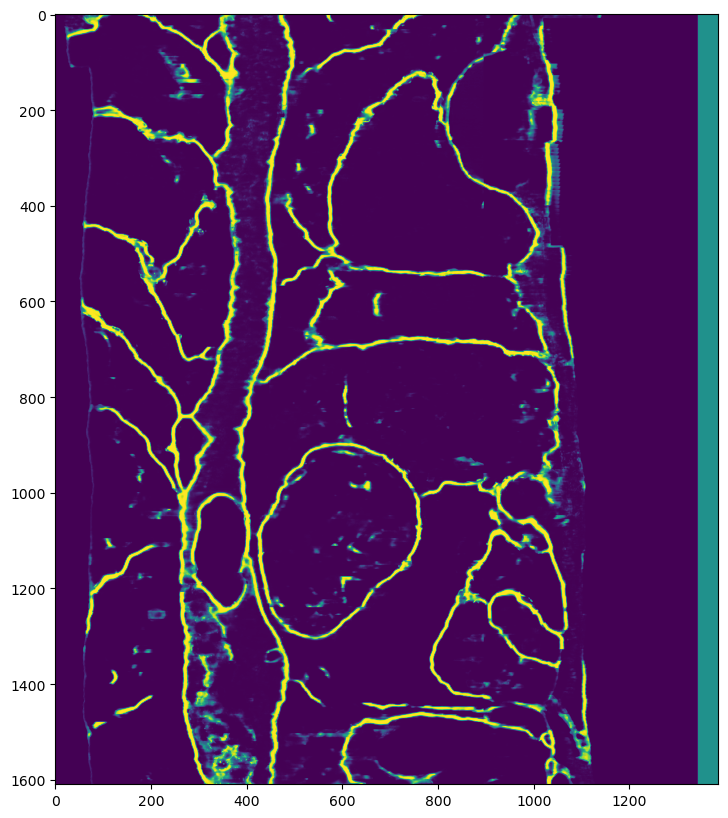

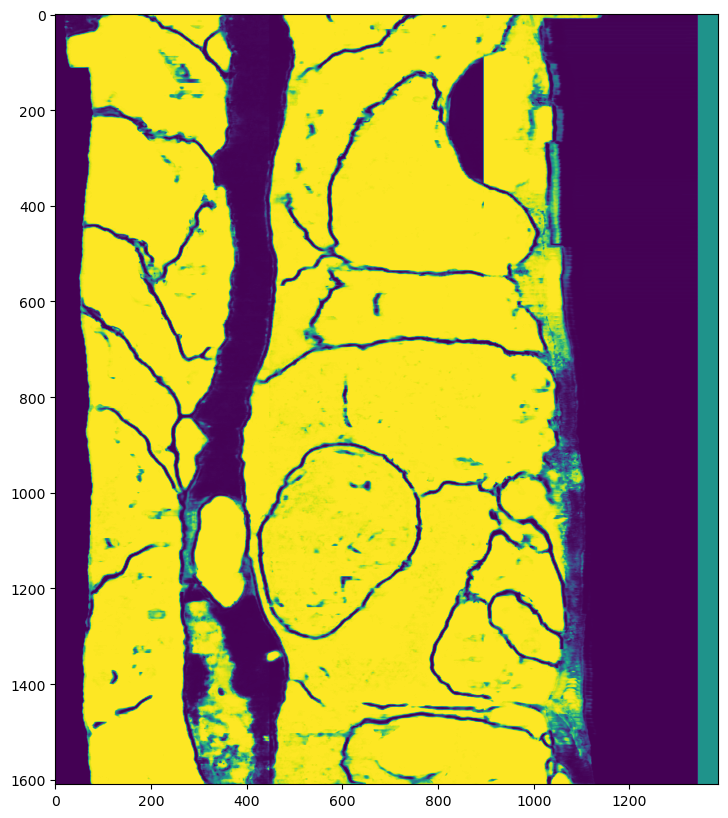

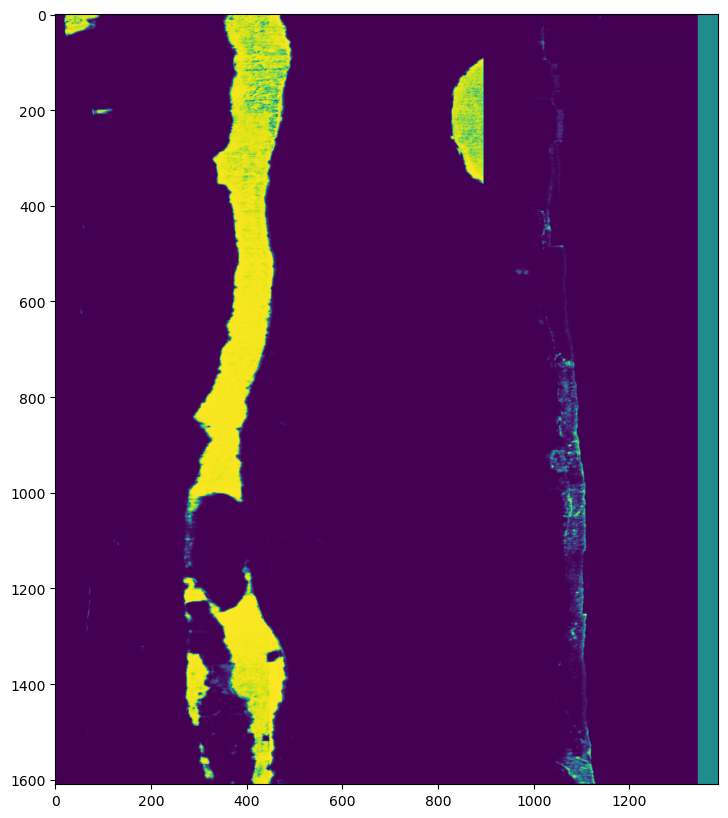

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(em[:, 0, :])
plt.show()
plt.figure(figsize=(10, 10))
print(em[:, 0, :].min())
plt.imshow(em[:, 0, :] == em[:, 0, :].min())
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(boundaries[:, 0, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(fg[:, 0, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(extra[:, 0, :])

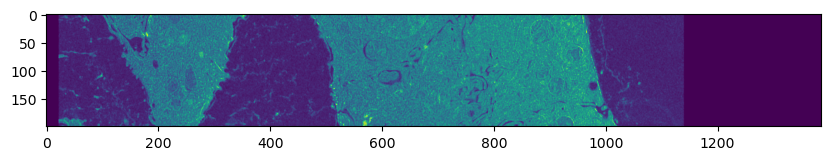

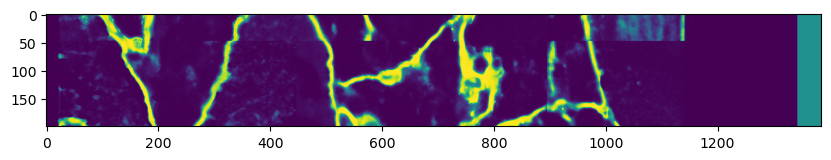

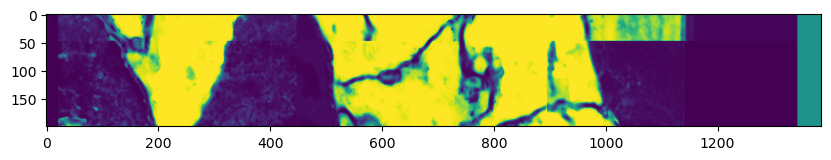

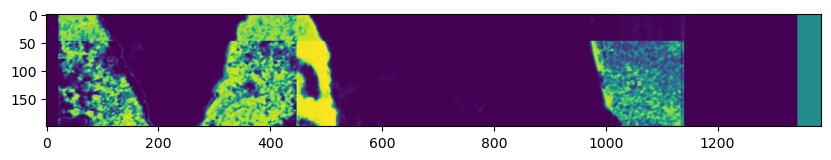

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(em[0, :, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(boundaries[0, :, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(fg[0, :, :])
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(extra[0, :, :])

## Open raw in napari

In [14]:
v = napari.Viewer()

In [15]:
v.add_image(em, name="raw")

<Image layer 'raw' at 0x7f08c4367580>

In [16]:
for ch in range(segmentation.shape[0]):
    v.add_labels(segmentation[ch, ...], name=f"segmentation ch {ch}")

In [9]:
# napari_add_group(f_em, "channels", v)